In [8]:
# General Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from selenium import webdriver
import main
import seaborn as sns
import chromedriver_autoinstaller
from datetime import datetime
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch
from matplotlib.colors import to_rgba
import matplotlib as mpl
from collections import defaultdict
import pickle

In [9]:
chromedriver_autoinstaller.install()

import warnings
warnings.filterwarnings('ignore')

## Pull Data

In [10]:
chromedriver_autoinstaller.install()

if __name__ == "__main__":
    driver = webdriver.Chrome()
    
# whoscored match centre url of the required match (Example: Barcelona vs Sevilla)
url = "https://www.whoscored.com/Matches/1640737/Live/England-Premier-League-2022-2023-Fulham-Chelsea"
match_data = main.getMatchData(driver, url, close_window=True)

# Match dataframe containing info about the match
matches_df = main.createMatchesDF(match_data)

# Events dataframe      
events_df = main.createEventsDF(match_data)

# match Id
matchId = match_data['matchId']

# Information about respective teams as dictionary
home_data = matches_df['home'][matchId]
away_data = matches_df['away'][matchId]
score = matches_df['score'][matchId]
score = ' ' + score.replace(':', '-') + ' '

home_name = home_data['name']
away_name = away_data['name']
date = match_data['startDate'].split('T')[0]
date_ = datetime.strptime(date, '%Y-%m-%d').date()
date_str = date_.strftime('%d/%m/%Y')

Region: England, League: Premier League, Season: 2022/2023, Match Id: 1640737


## Team and Player of Interest 
- Only thing you need to change
- Interested here in the away team - change if necessary
- In this instance it's João Félix 
- Change accordingly (use home template if want home player)

In [11]:
playerName = 'João Félix'
homeID = home_data['teamId']
awayID = away_data['teamId']

# Change both of these, ID is the one of interest 
ID = awayID
alt_ID = homeID

## Get 11 players with most minutes
- For our percentile plots 
- Seems unfair to plot vs subs 

In [12]:
# For the main team (one we're interested in)
team_players = events_df[events_df.teamId == ID].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team_players = pd.concat([team_players['playerName'], team_players['minute']], axis=1)
team_players['mins_played'] = team_players['max'] - team_players['min']
team_players = team_players.sort_values('mins_played', ascending=False)
team_players_names = team_players.playerName
team_players_names_top11 = team_players.playerName[:11].tolist()
team_players_names_top11

# For the other team
team2_players = events_df[events_df.teamId == alt_ID].groupby('playerName').agg({'minute': [min, max]}).reset_index()
team2_players = pd.concat([team2_players['playerName'], team2_players['minute']], axis=1)
team2_players['mins_played'] = team2_players['max'] - team2_players['min']
team2_players = team2_players.sort_values('mins_played', ascending=False)
team2_players_names = team2_players.playerName
team2_players_names_top11 = team2_players.playerName[:11].tolist()

team_players_names_top11


['Thiago Silva',
 'Kai Havertz',
 'Kalidou Koulibaly',
 'Kepa Arrizabalaga',
 'César Azpilicueta',
 'Lewis Hall',
 'Mateo Kovacic',
 'Trevoh Chalobah',
 'Mason Mount',
 'João Félix',
 'Denis Zakaria']

In [13]:
team_all_names = team_players_names.tolist()
team2_all_names = team2_players_names.tolist()

all_players = team_all_names + team2_all_names
all_players

['Thiago Silva',
 'Kai Havertz',
 'Kalidou Koulibaly',
 'Kepa Arrizabalaga',
 'César Azpilicueta',
 'Lewis Hall',
 'Mateo Kovacic',
 'Trevoh Chalobah',
 'Mason Mount',
 'João Félix',
 'Denis Zakaria',
 'Jorginho',
 'Carney Chukwuemeka',
 'Conor Gallagher',
 'Marc Cucurella',
 'Hakim Ziyech',
 'Tosin Adarabioyo',
 'Bernd Leno',
 'Tim Ream',
 'Antonee Robinson',
 'Carlos Vinícius',
 'Kenny Tete',
 'Andreas Pereira',
 'João Palhinha',
 'Willian',
 'Harrison Reed',
 'Bobby De Cordova-Reid',
 'Harry Wilson',
 'Tom Cairney',
 'Manor Solomon',
 'Dan James',
 'Nathaniel Chalobah']

## Data Engineering - xA
- Just shifting index by one won't capture actions that should qualify as a potential assist and ergo xA values. 
- E.g. if a player carries the ball/takes a 'ball touch' then the preceding action won't qualify as an assist if we just shift the index by one
- Hence we're going to get all key passes for each player from the events_df dataframe, then just iterate through subsequent indexes until we get the first shot 
- Then just merge the id on the xG df

In [14]:
keyPassCols = ['keyPassLong', 
               'keyPassShort', 
               'keyPassCross',
               'keyPassCorner', 
               'keyPassThroughball', 
               'keyPassFreekick', 
               'keyPassThrowin', 
               'keyPassOther'
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]

df_KP = pd.DataFrame(columns=['playerAssist', 'id'])

for player in all_players:
    index = []
    for col in keyPassCols:
        idxs = events_df[(events_df['playerName'] == player) &
                         (events_df[col] == 1)].index.values.tolist()
        for idx in idxs:
            if idx not in index:
                index.append(idx)

    # Now need to get correspoding id of subsequent shot, then just merge on the xA dataframe

    for idx in index:
        df = events_df.loc[idx+1:]

        for idx, row in df.iterrows():
            if any(row['type'] == x for x in shot_types):
                df_KP.loc[len(df_KP)] = [player, row['id']]
                break

            

df_KP

,playerAssist,id
0,Kai Havertz,2.496789e+09
1,Kai Havertz,2.496793e+09
2,Kai Havertz,2.496800e+09
3,Kai Havertz,2.496805e+09
4,Kalidou Koulibaly,2.496811e+09
5,Mateo Kovacic,2.496797e+09
6,Mateo Kovacic,2.496800e+09
7,Trevoh Chalobah,2.496791e+09
8,Mason Mount,2.496794e+09
9,Mason Mount,2.496794e+09


## XG Model
- Run shot data through our xG model, so we can get the xA and xG for individual players (and how they rank relative to distribution)
- First run through function which reduces it to the necessary form (described in detail in our xG model notebook)

In [15]:
feature_cols = ['id',
                'eventId',
                'teamId',
                'prevTeam',
                'x', 
                'y',
                'playerName', 
                'playerAssist',
                'minute', 
                'second',
                'type',
                'prevEvent',
                'isGoal',
                'shotRightFoot',
                'shotLeftFoot',
                'shotHead',
                'shotOpenPlay',
                'shotSetPiece',
#                 'shotCounter', 
                'shotDirectCorner',
                'penaltyScored',
                'penaltyMissed',
                'goalOwn',
                'shotLongPass',
                'shotShortPass',
                'shotCross',
                'shotThroughBall',
              ]

shot_types = ['SavedShot', 
              'MissedShots', 
              'Goal', 
              'ShotOnPost'
             ]

pitch_length_x = 100
pitch_length_y = 100


def shotData(df):
    df["passRecipient"] = df['playerName'].shift(-1)
    df['teamRecipient'] = df['teamId'].shift(-1)
    df['prevEvent'] = df['type'].shift(1)
    df['shotLongPass'] = df['keyPassLong'].shift(1)
    df['shotShortPass'] = df['keyPassShort'].shift(1)
    df['shotCross'] = df['keyPassCross'].shift(1)
    df['shotThroughBall'] = df['keyPassThroughball'].shift(1)
    df['playerAssist'] = df['playerName'].shift(1)
    df['prevTeam'] = df['teamId'].shift(1)

    column_to_move = df.pop("passRecipient")
    df.insert(29, "passRecipient", column_to_move)
    column_to_move = df.pop("teamRecipient")
    df.insert(27, "teamRecipient", column_to_move)
    column_to_move = df.pop('prevEvent')
    df.insert(11, "prevEvent", column_to_move)

    df_shots = df[df['type'].isin(shot_types)].reset_index(drop=True)[feature_cols]

    df_shots = df_shots[(df_shots['penaltyScored'] == False) & 
                        (df_shots['penaltyMissed'] == False) &
                        (df_shots['goalOwn'] == False)
                       ]
    df_shots['shotTakeOn'] = df_shots['prevEvent'] == 'TakeOn'
#     df_shots['shotDefensiveAction'] = df_shots['prevEvent'].isin(['Challenge', 'Tackle', 'Interception', 'Clearance',
#                                                                   'BallRecovery', 'BlockedPass'])

    df_shots['distance_to_goal'] = np.sqrt(((pitch_length_x - df_shots['x'])**2 + 
                                    (pitch_length_y - df_shots['y'])**2))
    df_shots['distance_to_center'] = abs(df_shots['y'] - pitch_length_y/2)
    df_shots['angle'] = np.absolute(np.degrees(np.arctan((abs((pitch_length_y/2) - df_shots['y'])) 
                                                         / (pitch_length_x - df_shots['x']))))


    df_shots = df_shots.drop(['prevEvent', 'penaltyScored', 'penaltyMissed', 'goalOwn', 'type'], axis=1)
    
    cat_cols = ['shotRightFoot',
            'shotLeftFoot',
            'shotHead',
            'shotOpenPlay',
            'shotSetPiece',
            'shotDirectCorner',
#             'shotCounter',
            'shotLongPass',
            'shotShortPass',
            'shotCross',
            'shotThroughBall',
            'shotTakeOn', 
#             'shotDefensiveAction'
           ]
    df_shots[cat_cols] *= 1
    
    obj_cols = [
            'shotLongPass',
            'shotShortPass',
            'shotCross',
            'shotThroughBall',
             ]
    
    for col in obj_cols:
        df_shots[col] = pd.to_numeric(df_shots[col])
    

    return df_shots 

In [16]:
data = shotData(events_df)
X_game = data.iloc[:, 11:]
Y_game = data['isGoal']

In [17]:
# Import our xG model 
xg_model = pickle.load(open('xgModel_XGBoost.sav', 'rb'))

In [18]:
y_pred_game = xg_model.predict_proba(X_game)
df_pred_game = pd.DataFrame(y_pred_game, columns = ['prob_no_goal', 'prob_goal'])
df_pred_game = pd.merge(data, df_pred_game, left_index=True, right_index=True)

for i in range(len(df_pred_game)):
    if (int(df_pred_game['teamId'][i]) != int(df_pred_game['prevTeam'][i])) or (df_pred_game['playerName'][i] == df_pred_game['playerAssist'][i]):
        df_pred_game['playerAssist'][i] = None
        
shots_to_merge = df_pred_game[['id','playerName', 'prob_goal']]
shots_to_merge


,id,playerName,prob_goal
0,2.496789e+09,Kai Havertz,0.246159
1,2.496789e+09,Lewis Hall,0.235215
2,2.496791e+09,Carlos Vinícius,0.070503
3,2.496791e+09,Mateo Kovacic,0.017572
4,2.496791e+09,Trevoh Chalobah,0.115869
5,2.496791e+09,João Félix,0.014631
6,2.496793e+09,João Félix,0.031432
7,2.496794e+09,Mateo Kovacic,0.088338
8,2.496794e+09,Thiago Silva,0.072765
9,2.496795e+09,Harrison Reed,0.025561


In [19]:
df_pred_game.groupby(['teamId'])['prob_goal'].sum()

teamId
15     2.245288
170    0.575648
Name: prob_goal, dtype: float32

## Get xG and xA numbers for players
- Doing for away team here, just use home/team1 players to do for the home team

In [20]:
# For xg
xg = pd.DataFrame(df_pred_game[df_pred_game['playerName'].isin(team_players_names_top11)].reset_index(drop=True).groupby(['playerName'])['prob_goal'].sum()).reset_index()

for player in team_players_names_top11:
    if player not in list(xg['playerName']):
        xg.loc[len(xg)] = [player, 0]


# # Scale Factor to get x-coordinate
min_xg = xg['prob_goal'].min()
max_xg = xg['prob_goal'].max()
player_xg = round(xg[xg['playerName'] == playerName].reset_index(drop=True)['prob_goal'][0],2)
sf_xg = (player_xg - min_xg) / (max_xg - min_xg)

xg

,playerName,prob_goal
0,César Azpilicueta,0.071642
1,João Félix,0.799482
2,Kai Havertz,0.312301
3,Kalidou Koulibaly,0.304118
4,Lewis Hall,0.304709
5,Mason Mount,0.031632
6,Mateo Kovacic,0.153017
7,Thiago Silva,0.072765
8,Trevoh Chalobah,0.115869
9,Kepa Arrizabalaga,0.000000


In [21]:
xa = shots_to_merge.merge(df_KP, how='outer', on='id')
xa = pd.DataFrame(xa[xa['playerAssist'].isin(team_players_names_top11)].reset_index(drop=True).groupby(['playerAssist'])['prob_goal'].sum()).reset_index()
for player in team_players_names_top11:
    if player not in list(xa['playerAssist']):
        xa.loc[len(xa)] = [player, 0]

# Scale Factor to get x-coordinate
min_xa = xa['prob_goal'].min()
max_xa = xa['prob_goal'].max()
player_xa = round(xa[xa['playerAssist'] == playerName].reset_index(drop=True)['prob_goal'][0],2)
sf_xa = (player_xa - min_xa) / (max_xa - min_xa)

xa


,playerAssist,prob_goal
0,João Félix,0.246159
1,Kai Havertz,0.387065
2,Kalidou Koulibaly,0.040620
3,Mason Mount,0.186625
4,Mateo Kovacic,0.633001
5,Trevoh Chalobah,0.014631
6,Thiago Silva,0.000000
7,Kepa Arrizabalaga,0.000000
8,César Azpilicueta,0.000000
9,Lewis Hall,0.000000


## Attempted Passes 

In [22]:
df_attempted_passes = events_df[(events_df['type'] == 'Pass') & 
                                (events_df['teamId'] == ID) & 
                                (events_df['playerName'].isin(team_players_names_top11))].reset_index(drop=True)
attempted_passes = pd.DataFrame(df_attempted_passes.groupby(['playerName'])['type'].count()).reset_index()

# Scale Factor to get x-coordinate
min_ap = attempted_passes['type'].min()
max_ap = attempted_passes['type'].max()
player_ap = int(attempted_passes[attempted_passes['playerName'] == playerName]['type'])
sf_ap = (player_ap-min_ap) / (max_ap-min_ap)

attempted_passes

,playerName,type
0,César Azpilicueta,43
1,Denis Zakaria,23
2,João Félix,23
3,Kai Havertz,32
4,Kalidou Koulibaly,75
5,Kepa Arrizabalaga,31
6,Lewis Hall,39
7,Mason Mount,37
8,Mateo Kovacic,52
9,Thiago Silva,54


## Completed Passes 

In [23]:
df_passes = events_df[(events_df['type'] == 'Pass') & (events_df['outcomeType'] == 'Successful') & 
                      (events_df['teamId'] == ID) & 
                      (events_df['playerName'].isin(team_players_names_top11))].reset_index(drop=True)
comp_passes = pd.DataFrame(df_passes.groupby(['playerName'])['type'].count()).reset_index()

# Scale Factor to get x-coordinate
min_cp = comp_passes['type'].min()
max_cp = comp_passes['type'].max()
player_cp = int(comp_passes[comp_passes['playerName'] == playerName]['type'])
sf_cp = (player_cp-min_cp) / (max_cp-min_cp)

comp_passes


,playerName,type
0,César Azpilicueta,31
1,Denis Zakaria,20
2,João Félix,16
3,Kai Havertz,27
4,Kalidou Koulibaly,63
5,Kepa Arrizabalaga,29
6,Lewis Hall,32
7,Mason Mount,24
8,Mateo Kovacic,42
9,Thiago Silva,47


## Touches 

In [24]:
df_touches = events_df[(events_df['isTouch'] == True) & 
                       (events_df['playerName'].isin(team_players_names_top11)) & 
                       (events_df['teamId'] == ID)]
player_touches = pd.DataFrame(df_touches.groupby(['playerName'])['type'].count()).reset_index()

ind_player_touches = df_touches[df_touches['playerName'] == playerName].reset_index(drop=True)
no_touches = len(ind_player_touches)

# Scale Factor to get x-coordinate
min_t = player_touches['type'].min()
max_t = player_touches['type'].max()
player_t = int(player_touches[player_touches['playerName'] == playerName]['type'])
sf_t = (player_t-min_t) / (max_t-min_t)

player_touches

,playerName,type
0,César Azpilicueta,55
1,Denis Zakaria,33
2,João Félix,41
3,Kai Havertz,54
4,Kalidou Koulibaly,87
5,Kepa Arrizabalaga,35
6,Lewis Hall,60
7,Mason Mount,50
8,Mateo Kovacic,67
9,Thiago Silva,64


## Progressive Passes 

In [25]:
df_passes = events_df[(events_df['type'] == 'Pass') & (events_df['outcomeType'] == 'Successful') & 
                      (events_df['teamId'] == ID) & 
                      (events_df['playerName'].isin(team_players_names_top11))].reset_index(drop=True)

df_passes['ProgPass'] = ''

for i in range(len(df_passes)):
    x_0 = 120*(df_passes['x'][i])/100
    y_0 = 80*(df_passes['y'][i])/100
    x_1 = 120*(df_passes['endX'][i])/100
    y_1 = 80*(df_passes['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_passes['ProgPass'][i] = 1
    else:
        df_passes['ProgPass'][i] = 0
        
df_passes_succ = df_passes[df_passes['outcomeType'] == 'Successful']
prog_passes = pd.DataFrame(df_passes_succ.groupby('playerName')['ProgPass'].sum()).reset_index()
df_passes_succ

# Scale Factor to get x-coordinate
min_pp = prog_passes['ProgPass'].min()
max_pp = prog_passes['ProgPass'].max()
player_pp = prog_passes[prog_passes['playerName'] == playerName].reset_index(drop=True)['ProgPass'][0]
sf_pp = (player_pp - min_pp) / (max_pp - min_pp)

prog_passes

,playerName,ProgPass
0,César Azpilicueta,4
1,Denis Zakaria,1
2,João Félix,2
3,Kai Havertz,0
4,Kalidou Koulibaly,6
5,Kepa Arrizabalaga,2
6,Lewis Hall,0
7,Mason Mount,1
8,Mateo Kovacic,7
9,Thiago Silva,7


## Progressive Carries 
- Opta doesn't seemingly track carries, so we have to derive ourselves

In [26]:
df_carries = pd.DataFrame()
min_len = 3
max_len = 60
min_time = 1
max_time = 12

for idx, match_event in events_df.iterrows():
    if idx == len(events_df) - 1:
        break
    
    cur_team = match_event['teamId']
    idx_next = idx + 1
    events_df_next = events_df.loc[idx_next]
    take_ons = 0
    loop = True
    count = 0 
    
    while loop:
        next_events = events_df.loc[idx_next]
        
        if next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Successful':
            take_ons += 1
            loop = True
        
        elif (next_events['type'] == 'TakeOn' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['teamId'] != cur_team and next_events['type'] == 'Challenge' and next_events['outcomeType'] == 'Unsuccessful') or (next_events['type'] == 'Foul'):
            loop = True
            
        else:
            loop = False
            
        idx_next += 1
        count += 0 
        

    same_team = cur_team == next_events['teamId']
    not_ball_touch = match_event['type'] != 'BallTouch'
    dx = 105 * (match_event['endX'] - next_events['x'])/100
    dy = 68 * (match_event['endY'] - next_events['y'])/100
    min_dist = dx**2 + dy**2 >= min_len**2
    max_dist = dx**2 + dy**2 <= max_len**2
    same_period = match_event['period'] == next_events['period']
    
    valid_carry = same_team & not_ball_touch & min_dist & max_dist & same_period 
    
    if valid_carry:
        carry = pd.DataFrame()
        prev = match_event
        nxt = next_events
        carry.loc[0, 'eventId'] = prev['eventId'] + count
        carry['id'] = prev['id'] + count
        carry['teamId'] = nxt['teamId']
        carry['x'] = prev['endX']
        carry['y'] = prev['endY']
        carry['period'] = nxt['period']
        carry['type'] = carry.apply(lambda x: {'value': 99, 'displayName': 'Carry'}, axis=1)
        carry['outcomeType'] = 'Successful'
        carry['qualifiers'] = carry.apply(
            lambda x: {'type': {'value': 999, 'displayName': 'takeOns'}, 'value': str(take_ons)}, axis=1)
        carry['satisfiedEventsTypes'] = carry.apply(lambda x: [], axis=1)
        carry['isTouch'] = True
        carry['playerId'] = nxt['playerId']
        carry['playerName'] = nxt['playerName']
        carry['endX'] = nxt['x']
        carry['endY'] = nxt['y']
        
        df_carries = pd.concat([df_carries, carry], ignore_index=True, sort=False)


In [27]:
df_carries = df_carries[(df_carries['teamId'] == ID) & 
                        (df_carries['playerName'].isin(team_players_names_top11))].reset_index(drop=True)

df_carries['ProgCarry'] = ''
for i in range(len(df_carries)):
    x_0 = 120*(df_carries['x'][i])/100
    y_0 = 80*(df_carries['y'][i])/100
    x_1 = 120*(df_carries['endX'][i])/100
    y_1 = 80*(df_carries['endY'][i])/100
    
    beg_dist = np.sqrt((120 - x_0)**2 + (40 - y_0)**2)
    end_dist = np.sqrt((120 - x_1)**2 + (40 - y_1)**2)

    if end_dist/beg_dist <= 0.75:
        df_carries['ProgCarry'][i] = 1
    else:
        df_carries['ProgCarry'][i] = 0
        
prog_carries = pd.DataFrame(df_carries.groupby('playerName')['ProgCarry'].sum()).reset_index()

# Scale Factor to get x-coordinate
min_pc = prog_carries['ProgCarry'].min()
max_pc = prog_carries['ProgCarry'].max()
player_pc = prog_carries[prog_carries['playerName'] == playerName].reset_index(drop=True)['ProgCarry'][0]
sf_pc = (player_pc - min_pc) / (max_pc - min_pc)

prog_carries

,playerName,ProgCarry
0,César Azpilicueta,0
1,Denis Zakaria,0
2,João Félix,3
3,Kai Havertz,3
4,Kalidou Koulibaly,0
5,Kepa Arrizabalaga,0
6,Lewis Hall,2
7,Mason Mount,2
8,Mateo Kovacic,1
9,Thiago Silva,0


## Successful Take Ons

In [28]:
df_takeons = events_df[(events_df['type'] == 'TakeOn') & (events_df['outcomeType'] == 'Successful') & 
                      (events_df['teamId'] == ID) & 
                      (events_df['playerName'].isin(team_players_names_top11))].reset_index(drop=True)
df_takeons = pd.DataFrame(df_takeons.groupby('playerName')['id'].count()).reset_index()

for player in team_players_names_top11:
    if player not in list(df_takeons['playerName']):
        df_takeons.loc[len(df_takeons)] = [player, 0]

# Scale Factor to get x-coordinate
min_to = df_takeons['id'].min()
max_to = df_takeons['id'].max()
player_to = df_takeons[df_takeons['playerName'] == playerName].reset_index(drop=True)['id'][0]
sf_to = (player_to - min_to) / (max_to - min_to)
        
df_takeons

,playerName,id
0,César Azpilicueta,1
1,João Félix,2
2,Kalidou Koulibaly,1
3,Mason Mount,1
4,Thiago Silva,0
5,Kai Havertz,0
6,Kepa Arrizabalaga,0
7,Lewis Hall,0
8,Mateo Kovacic,0
9,Trevoh Chalobah,0


## Ball Wins 
- Includes tackles, interceptions, blocked passes and aerials which win the ball back
- Just add a recipient column for player (which we'll use later) and for team, to judge whether team regained possession

In [29]:
events_df["passRecipient"] = events_df['playerName'].shift(-1)
events_df['teamRecipient'] = events_df['teamId'].shift(-1)
column_to_move = events_df.pop("passRecipient")
events_df.insert(26, "passRecipient", column_to_move)
column_to_move = events_df.pop("teamRecipient")
events_df.insert(27, "teamRecipient", column_to_move)

In [30]:
df_ballwins = events_df[(events_df['type'].isin(['Tackle', 'Interception', 'BlockedPass', 'Aerial'])) & 
                        (events_df['outcomeType'] == 'Successful') & 
                        (events_df['teamId'] == ID) & 
                        (events_df['teamId'] == events_df['teamRecipient']) & 
                        (events_df['playerName'].isin(team_players_names_top11))].reset_index(drop=True)
df_ballwins = pd.DataFrame(df_ballwins.groupby('playerName')['id'].count()).reset_index()

for player in team_players_names_top11:
    if player not in list(df_ballwins['playerName']):
        df_ballwins.loc[len(df_ballwins)] = [player, 0]
        
# Scale Factor to get x-coordinate
min_bw = df_ballwins['id'].min()
max_bw = df_ballwins['id'].max()
player_bw = df_ballwins[df_ballwins['playerName'] == playerName].reset_index(drop=True)['id'][0]
sf_bw = (player_bw - min_bw) / (max_bw - min_bw)

df_ballwins


,playerName,id
0,César Azpilicueta,2
1,Denis Zakaria,2
2,Kai Havertz,3
3,Kalidou Koulibaly,4
4,Lewis Hall,3
5,Mason Mount,1
6,Mateo Kovacic,2
7,Thiago Silva,2
8,Trevoh Chalobah,1
9,Kepa Arrizabalaga,0


## xThreat
- Want team values for 3 xThreat - xThreat via Pass & Carry, and xThreat received (i.e. ability to produce and receive)
- Using Karun Singh's values

###  xThreat via Pass

In [31]:
xT_list = []
path = "https://karun.in/blog/data/open_xt_12x8_v1.json"
xT = pd.read_json(path)
xT = np.array(xT)
xT_rows, xT_cols = xT.shape

In [32]:
# Already have all completed passes for away team from earlier (df_passes)
xT_list = []
for name in team_players_names_top11:
    test = df_passes[df_passes['playerName'] == name]
    
    if len(test) > 0:
        test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
        test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
        test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
        test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
        test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_diff'] = test['xT_end'] - test['xT_start']
        xT_added = test['xT_diff'].sum()

        xT_list.append([name, xT_added])
        
    else:
        xT_list.append([name, 0])

xT_pass = pd.DataFrame(xT_list)

# Scale Factor to get x-coordinate
min_xtp = xT_pass[1].min()
max_xtp = xT_pass[1].max()
player_xtp = round(xT_pass[xT_pass[0] == playerName].reset_index(drop=True)[1][0],2)
sf_xtp = (player_xtp - min_xtp) / (max_xtp - min_xtp)

xT_pass


,0,1
0,Thiago Silva,0.347922
1,Kai Havertz,-0.194279
2,Kalidou Koulibaly,0.001786
3,Kepa Arrizabalaga,-0.085690
4,César Azpilicueta,0.380403
5,Lewis Hall,-0.484132
6,Mateo Kovacic,0.235439
7,Trevoh Chalobah,0.129810
8,Mason Mount,0.320489
9,João Félix,0.297164


### xThreat via Carry  

In [33]:
# Already have all completed carries for away team from earlier (df_carries)
xT_carry_list = []
for name in team_players_names_top11:
    test = df_carries[df_carries['playerName'] == name]
    
    if len(test) > 0:
        test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
        test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
        test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
        test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
        test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_diff'] = test['xT_end'] - test['xT_start']
        xT_added = test['xT_diff'].sum()

        xT_carry_list.append([name, xT_added])
        
    else:
        xT_carry_list.append([name, 0])
    
xT_carry = pd.DataFrame(xT_carry_list)

# Scale Factor to get x-coordinate
min_xtc = xT_carry[1].min()
max_xtc = xT_carry[1].max()
player_xtc = round(xT_carry[xT_carry[0] == playerName].reset_index(drop=True)[1][0],2)
sf_xtc = (player_xtc - min_xtc) / (max_xtc - min_xtc)

xT_carry


,0,1
0,Thiago Silva,0.224997
1,Kai Havertz,0.102886
2,Kalidou Koulibaly,-0.024780
3,Kepa Arrizabalaga,0.026788
4,César Azpilicueta,-0.246686
5,Lewis Hall,0.195425
6,Mateo Kovacic,-0.000588
7,Trevoh Chalobah,-0.041421
8,Mason Mount,0.014931
9,João Félix,0.036367


### xThreat Received (via Pass)
- Same as one before, just switch playerName to passRecipient

In [34]:
xT_received_list = []
for name in team_players_names_top11:
    test = df_passes[df_passes['passRecipient'] == name]
    
    if len(test) > 0:
        test['x1_bin'] = pd.cut(test['x'], bins=xT_cols, labels=False)
        test['x2_bin'] = pd.cut(test['endX'], bins=xT_cols, labels=False)
        test['y1_bin'] = pd.cut(test['y'], bins=xT_rows, labels=False)
        test['y2_bin'] = pd.cut(test['endY'], bins=xT_rows, labels=False)
        test['xT_start'] = test[['x1_bin', 'y1_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_end'] = test[['x2_bin', 'y2_bin']].apply(lambda x:xT[x[1]][x[0]], axis=1)
        test['xT_diff'] = test['xT_end'] - test['xT_start']
        xT_added = test['xT_diff'].sum()

        xT_received_list.append([name, xT_added])
        
    else:
        xT_received_list.append([name, 0])

xT_received_list = pd.DataFrame(xT_received_list)

# Scale Factor to get x-coordinate
min_xtr = xT_received_list[1].min()
max_xtr = xT_received_list[1].max()
player_xtr = round(xT_received_list[xT_received_list[0] == playerName].reset_index(drop=True)[1][0],2)
sf_xtr = (player_xtr - min_xtr) / (max_xtr - min_xtr)

xT_received_list


,0,1
0,Thiago Silva,-0.005420
1,Kai Havertz,0.343050
2,Kalidou Koulibaly,-0.284677
3,Kepa Arrizabalaga,0.051774
4,César Azpilicueta,0.241963
5,Lewis Hall,0.129518
6,Mateo Kovacic,-0.037840
7,Trevoh Chalobah,0.201545
8,Mason Mount,-0.100551
9,João Félix,0.159934


## Key Events
- For our viz, we want to plot key events for that player
- Includes shots, key passes, takeons and ball wins 
- Player in question in João Félix as mentioned at the top 

### Shots  

In [35]:
shots = df_pred_game[df_pred_game['playerName'] == playerName].reset_index(drop=True)[['id','x', 'y', 'prob_goal', 'isGoal']]
shots['marker_size'] = shots['prob_goal'] * 800

shots = shots[shots['isGoal'] == False]
no_shots = len(shots)

goals = shots[shots['isGoal'] == True]
no_goals = len(goals)

shots

,id,x,y,prob_goal,isGoal,marker_size
0,2.496791e+09,86.8,68.4,0.014631,False,11.704877
1,2.496793e+09,74.6,45.8,0.031432,False,25.145510
2,2.496797e+09,85.5,63.8,0.068081,False,54.464828
3,2.496800e+09,95.6,53.8,0.564920,False,451.935730
4,2.496800e+09,85.7,37.1,0.097570,False,78.056145
5,2.496805e+09,76.4,56.7,0.022848,False,18.278513


### Key Passes  

In [36]:
keypasses = events_df[(events_df['playerName'] == playerName) &
                      (events_df['type'] == 'Pass')].reset_index(drop=True)
keypasses['isKeyPass'] = ''

for i in range(len(keypasses)):
    for col in keyPassCols:
        if keypasses[col][i] == True:
            keypasses['isKeyPass'][i] = 1
            break
        else:
            keypasses['isKeyPass'][i] = 0
            

keypasses = keypasses[['playerName', 'x', 'y', 'endX', 'endY', 'outcomeType', 'isKeyPass']]
keypasses = keypasses[(keypasses['outcomeType'] == 'Successful') &
                      (keypasses['isKeyPass'] == 1)]
no_keypasses = len(keypasses)

assists = events_df[(events_df['playerName'] == playerName) & (events_df['assist'] == True)]
no_assists = len(assists)


keypasses


,playerName,x,y,endX,endY,outcomeType,isKeyPass
2,João Félix,93.0,25.1,89.9,46.7,Successful,1


### Take Ons

In [37]:
takeons = events_df[(events_df['playerName'] == playerName) & 
                    (events_df['type'] == 'TakeOn')].reset_index(drop=True)
no_takeons = len(takeons)

succ_takeons = takeons[takeons['outcomeType'] == 'Successful'][['x', 'y']]
no_succ_takeons = len(succ_takeons)


### Ball Wins  

In [38]:
ballwins = events_df[(events_df['type'].isin(['Tackle', 'Interception', 'BlockedPass', 'Aerial'])) & 
                     (events_df['outcomeType'] == 'Successful') & 
                     (events_df['teamId'] == ID) & 
                     (events_df['teamId'] == events_df['teamRecipient']) & 
                     (events_df['playerName'] == playerName)].reset_index(drop=True)[['x', 'y']]
no_ballwins = len(ballwins)
ballwins

,x,y


## Plot  

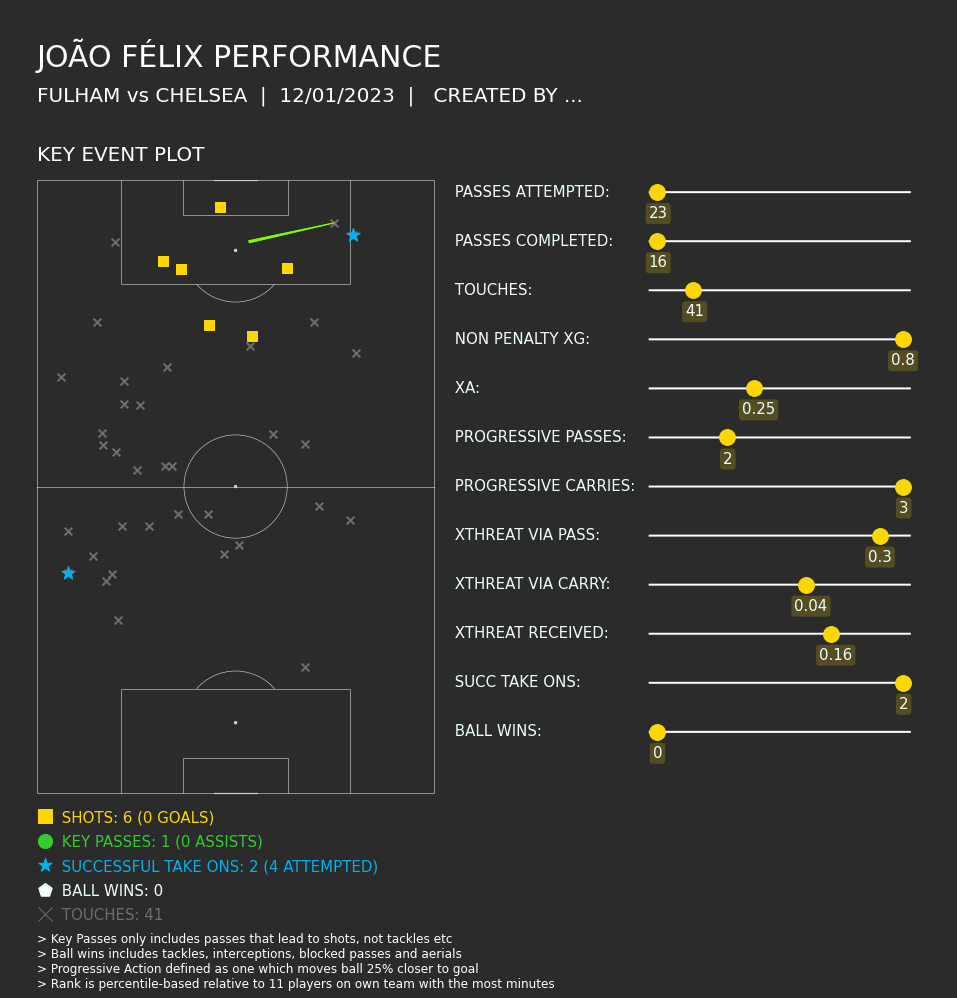

In [39]:
pitch = VerticalPitch(pitch_type='opta', pitch_color='#2B2B2B', line_color='#c7d5cc',pad_top=0, pad_left = 7.5,
                      pad_bottom = 40, pad_right = 130, pitch_width=80, pitch_length=120,
                      linewidth=0.6)

fig, axs = pitch.grid(figheight=15, ncols=1, axis=False, endnote_height=0.02)

fig.set_facecolor("#2B2B2B")
mpl.rcParams['figure.dpi'] = 800


axs['title'].text(0, 0.7, playerName.upper() + ' Performance '.upper(), 
                  ha='left', va='center', color='white',
                  fontsize=30, fontname='Sans Serif')
axs['title'].text(0, 0.45, 
                  home_name.upper() + ' vs ' + away_name.upper() + '  |  ' + date_str + '  |  ' + ' Created by'.upper() + ' ...', 
                  ha='left', va='center', color='white',
                  fontsize=20, fontname='Sans Serif')

pitch.annotate(text='Key Event Plot'.upper(), xytext=(104,100), xy=(60,40), color='White',
                  va='center', ha='left', fontsize=20, fontname='Sans Serif', ax=axs['pitch'])

# Shots Map
player_shots = pitch.scatter(shots.x, shots.y, s=100,
                             edgecolor='gold', color = 'gold' , marker='s', linewidth=1, 
                             zorder=5, ax=axs['pitch'])


# Key Pass Map
pass_arrow_kp = pitch.lines(keypasses.x, keypasses.y,
                            keypasses.endX, keypasses.endY, lw=3,
                            color='lawngreen', zorder=4,comet=True, ax=axs['pitch'])

# pass_nodes_kp = pitch.scatter(keypasses.endX, keypasses.endY, s=100,
#                               color='lawngreen', linewidth=1, zorder=3, ax=axs['pitch'])

# Take Ons
nodes_to = pitch.scatter(succ_takeons.x, succ_takeons.y, s=200,
                         color='#00B2EE', linewidth=1, marker='*', zorder=2, ax=axs['pitch'])

# Ball Wins 
nodes_bw = pitch.scatter(ballwins.x, ballwins.y, s=150,
                              color='azure', linewidth=1, marker='p', zorder=2, ax=axs['pitch'])

# Touches
nodes_t = pitch.scatter(ind_player_touches.x, ind_player_touches.y, s=60, marker='x',
                        edgecolor='#6E6E6E', linewidth=2, color='#6E6E6E', zorder=1, ax=axs['pitch'])

# Text
marker_shots = pitch.scatter(-3.75, 98, s=200,
                           color='gold', linewidth=1, marker='s', zorder=7, ax=axs['pitch'])
pitch.annotate(text=' Shots: '.upper() + str(no_shots) + ' (' + str(no_goals) + ' GOALS)', 
                      xytext=(-4, 95), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='gold', ax=axs['pitch'])

marker_kp = pitch.scatter(-7.75, 98, s=200,
                           color='limegreen', linewidth=1, marker='o', zorder=7, ax=axs['pitch'])
pitch.annotate(text=' Key Passes: '.upper() + str(no_keypasses) + ' (' + str(no_assists) + ' ASSISTS)', 
                      xytext=(-8, 95), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='limegreen', ax=axs['pitch'])

marker_to = pitch.scatter(-11.75, 98, s=200,
                           color='#00B2EE', linewidth=1, marker='*', zorder=7, ax=axs['pitch'])
pitch.annotate(text=' Successful Take Ons: '.upper() + str(no_succ_takeons) + ' (' + str(no_takeons) + ' ATTEMPTED)', 
                      xytext=(-12, 95), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='#00B2EE', ax=axs['pitch'])

marker_bw = pitch.scatter(-15.75, 98, s=200,
                           color='azure', linewidth=1, marker='p', zorder=7, ax=axs['pitch'])
pitch.annotate(text=' Ball Wins: '.upper() + str(no_ballwins) , 
                      xytext=(-16, 95), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])

marker_bw = pitch.scatter(-19.75, 98, s=200,
                           color='#6E6E6E', linewidth=1, marker='x', zorder=7, ax=axs['pitch'])
pitch.annotate(text=' Touches: '.upper() + str(no_touches) , 
                      xytext=(-20, 95), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='#6E6E6E', ax=axs['pitch'])



x_min = -56
x_max = -118
x_diff = x_max-x_min

# Distribution rank (against own team)
pitch.annotate(text=' Passes Attempted: '.upper(), 
                      xytext=(98, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(98, -54,
                         98, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_ap
marker_pa = pitch.scatter(98, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_ap), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(94.5, x_pos+2), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])




pitch.annotate(text=' Passes Completed: '.upper(), 
                      xytext=(90, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(90, -54,
                         90, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_cp
marker_pa = pitch.scatter(90, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_cp), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(86.5, x_pos+2), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])


pitch.annotate(text=' Touches: '.upper(), 
                      xytext=(82, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(82, -54,
                         82, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_t
marker_pa = pitch.scatter(82, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_t), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(78.5, x_pos+2), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])



pitch.annotate(text=' Non Penalty XG: '.upper(), 
                      xytext=(74, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(74, -54,
                         74, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_xg
marker_pa = pitch.scatter(74, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_xg), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(70.5, x_pos+3), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])


pitch.annotate(text=' XA: '.upper(), 
                      xytext=(66, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(66, -54,
                         66, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_xa
marker_pa = pitch.scatter(66, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_xa), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(62.5, x_pos+3), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])


pitch.annotate(text=' Progressive Passes: '.upper(), 
                      xytext=(58, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(58, -54,
                         58, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_pp
marker_pa = pitch.scatter(58, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_pp), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(54.5, x_pos+1), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])



pitch.annotate(text=' Progressive Carries: '.upper(), 
                      xytext=(50, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(50, -54,
                         50, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_pc
marker_pa = pitch.scatter(50, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_pc), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(46.5, x_pos+1), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])




pitch.annotate(text=' xThreat via Pass: '.upper(), 
                      xytext=(42, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(42, -54,
                         42, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_xtp
marker_pa = pitch.scatter(42, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_xtp), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(38.5, x_pos+3), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])



pitch.annotate(text=' xThreat via Carry: '.upper(), 
                      xytext=(34, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(34, -54,
                         34, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_xtc
marker_pa = pitch.scatter(34, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_xtc), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(30.5, x_pos+3), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])




pitch.annotate(text=' xThreat Received: '.upper(), 
                      xytext=(26, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(26, -54,
                         26, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_xtr
marker_pa = pitch.scatter(26, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_xtr), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(22.5, x_pos+3), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])




pitch.annotate(text=' Succ Take Ons: '.upper(), 
                      xytext=(18, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(18, -54,
                         18, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_to
marker_pa = pitch.scatter(18, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_to), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(14.5, x_pos+1), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])




pitch.annotate(text=' Ball Wins: '.upper(), 
                      xytext=(10, -4), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])
line1 = pitch.lines(10, -54,
                         10, -120, lw=2, color='white',
                         zorder=1, linestyle='-', ax=axs['pitch'])
x_pos = -56 + x_diff * sf_bw
marker_pa = pitch.scatter(10, x_pos, s=250,
                           color='gold', linewidth=1, marker='o', zorder=8, ax=axs['pitch'])
pitch.annotate(text=str(player_bw), 
               bbox=dict(facecolor='gold', edgecolor='none', boxstyle='round,pad=.2', alpha=0.2),
                      xytext=(6.5, x_pos+1), xy=(60, 40), ha='left', va='center',
                      fontname = 'Sans Serif', fontsize=15, color='azure', ax=axs['pitch'])

axs['endnote'].text(0.00, 1.05, '> Key Passes only includes passes that lead to shots, not tackles etc \n> Ball wins includes tackles, interceptions, blocked passes and aerials \n> Progressive Action defined as one which moves ball 25% closer to goal \n> Rank is percentile-based relative to 11 players on own team with the most minutes', 
                    color='white',
                    va='center', ha='left', fontsize=12, fontname = 'Sans Serif')

fig.savefig('keyActions_and_metrics.png', dpi=300)